# Statistical Arbitrage and Mean Reversion: A Study on Pairs Trading Strategy

### 1. Background

*Pairs trading* stands as a quintessential strategy within the hedge fund domain, predicated on capitalizing upon transient discrepancies from a long-standing equilibrium pricing between two equities. Traditional methodologies for identifying trading pairs have predominantly relied upon correlation and a suite of non-parametric decision-making frameworks. Instead, we choose to find a potential matching partner for each stock by finding the security that minimizes the sum of squared deviations between the two normalized price series [1]

In lieu of relying on mere correlation, this study advocates for the selection of trading pairs anchored in the existence of a cointegrating relationship between the stock price series. Cointegration ensures that the linear amalgamation of the two stock prices yields a stationary process—a cornerstone for the formation of a mean-reverting portfolio.

The theoretical underpinning of cointegration suggests that any divergence from the long-term equilibrium between two cointegrated stocks is a temporary phenomenon, with expectations firmly rooted in a reversion to the mean. Engaging in this strategy entails initiating a long position when the portfolio's value markedly subsides below its equilibrium, liquidating the position as it gravitates back towards its anticipated value. Conversely, a short position is warranted when the portfolio's value appreciably surges above its equilibrium, unwinding the position as it converges to its normative state.

Several pivotal inquiries shape the development of a pairs trading strategy: the identification of trading pairs, the determination of significant deviation from equilibrium to enter a position, and the optimal juncture for position exit. The aim of this study is not to evaluate the profitability of a pairs trading strategy but rather to cultivate a robust method for its implementation. We commence by delineating a technique for the identification of trading pairs through the Augmented Dickey Fuller test and Johansen cointegration test. Subsequently, the cointegrating relationship is quantified via regression analysis. The residual series from the cointegrating equation encapsulates the dynamics of our mean-reverting portfolio.

Pairs trading is a systematic investment strategy executed in three main steps. First, we select potentially cointegrated stock pairs through statistical analysis. Second, we perform cointegration tests to confirm whether these pairs truly share a long-term equilibrium relationship. Finally, we design a trading strategy by analyzing the spread dynamics between the cointegrated pairs to establish effective entry and exit rules. This structured approach aims to capitalize on market inefficiencies while managing risk.

### 2. Methodologies [2]

### 2.1 Pair selection

During the formation period, we exclude S&P 500 stocks with any non-trading days to prioritize liquidity. We then create a cumulative total returns index for each stock, reflecting price movements and dividends. Pairs are formed by choosing stocks with the least squared deviations in their normalized price series, ensuring a tight match in their price movements. We also consider pairings sector to explore sector-influenced relationships. This process results in pairs that are both liquid and closely aligned for our trading strategy.







### 2.2 Cointegration Test

We commence by pinpointing the top 20 stock pairs with the smallest normalized price distances. Subsequently, we apply cointegration tests to these selected pairs to confirm the presence of cointegration.

In assessing the cointegration of two time series, $x(t)$ and $y(t)$, we model the relationship as:

$$
y(t) = \alpha + \beta x(t) + r(t)
$$

where $r(t)$ represents the residual series and can be further expressed as:

$$
r(t) = \rho r(t-1) + \epsilon(t)
$$

In this model, $\epsilon(t)$ denotes the innovation term. For $x(t)$ and $y(t)$ to be deemed cointegrated, the absolute value of $\rho$, denoted as $|\rho|$, must be less than 1, indicating that the residual series, $r(t)$, does not possess a unit root.

Determining the threshold for $|\rho|$ to be significantly less than 1 is the challenge addressed by unit-root tests. The `statsmodels` package in Python, for instance, offers more sophisticated models for assessing cointegration. A well-known unit-root test is the Augmented Dickey-Fuller (ADF) test, which tests the null hypothesis that a unit root is present against the alternative hypothesis of stationarity. Here, a low p-value suggests strong evidence against the presence of a unit root, thus supporting stationarity.

In addition, the Johansen test improves on two-step methods like CADF by simultaneously determining hedge ratios and testing for cointegration, reducing error accumulation. Unlike pair-based tests, the Johansen test can be applied to multiple stocks, enhancing its utility for portfolio analysis.

This test examines the rank of matrix $\Pi$ in Error-Correction Model to determine the number of cointegration relationships. In our code, we use 95% level critical value to determine the test. The null hypothesis $r = 0$ indicates no cointegration, $r = 1$ suggests at most one relationship, and so on. The test's eigenvectors also provide the hedge ratios necessary for portfolio construction.

After conducting both ADF and Johansen cointegration tests on the 20 pairs with the shortest normalized price distances, we have identified 7 pairs that exhibit cointegration. Notably, these pairs predominantly belong to the same GICS sector or represent shares of the same entity with different classes. For the purposes of our analysis, we will exclude the first pair that consists of shares with different classes, focusing on pairs within the same industry for more robust sector-specific insights.

In [2]:
import quant.screening
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
sp500_prices_df = pd.read_csv('../data/sp500_daily.csv', index_col='Date')
sp500_table = quant.screening.get_sp500_table()
filtered_data = quant.screening.filter_data(sp500_prices_df)
quant.screening.create_screening_result_df(filtered_data, sp500_table)

,Pair 1,Pair 2,Distance,Sector 1,Sector 2
0,FOX,FOXA,0.156441,Communication Services,Communication Services
1,AVB,INVH,0.352817,Real Estate,Real Estate
2,CNP,SRE,0.442587,Utilities,Utilities
3,DTE,LNT,0.511368,Utilities,Utilities
4,CMS,DTE,0.526707,Utilities,Utilities
5,PPL,SRE,0.540921,Utilities,Utilities
6,ED,KO,0.577782,Utilities,Consumer Staples


### 2.3 Trading rule design

Given the log-prices of two stocks,$y_{1t}$ and $y_{2t}$ , if they are cointegrated, then the spread $z_t = y_{1t} - \gamma y_{2t}$ is stationary and can be represented as:

$$
z_t = y_{1t} - \gamma y_{2t} = \mu + \epsilon_t
$$

where $\mu$ denotes the equilibrium value of the spread and $\epsilon_t$ is the stationary residual with a zero mean. The relationship also restructures into a familiar linear regression model:

$$
y_{1t} = \mu + \gamma y_{2t} + \epsilon_t
$$

To perform a Least Squares (LS) regression over \( T \) observations, we minimize the following objective function:

$$
minimize_{\mu, \gamma} \sum_{t=1}^{T} (y_{1t} - (\mu + \gamma y_{2t}))^2
$$

Alternatively, using vector notation with $y_1$ and $y_2$ to represent the stacked observations, the objective becomes:

$$
minimize_{\mu, \gamma} \lVert y_1 - (\mu \mathbf{1} + \gamma y_2) \rVert^2
$$

In the context of a trading strategy, after estimating the parameters $\mu$ and $\gamma$ through regression, we can calculate the spread:

$$
z_t = y_{1t} - \gamma y_{2t}
$$

The spread $z_t$ is then monitored against a pre-defined threshold level. When the spread deviates significantly, this may signal an opportunity for a trade:

- **Long Signal**: If $z_t$ falls below the threshold, this might indicate that stock 1 is undervalued relative to stock 2, suggesting a potential long position in stock 1 and a short sell position in stock 2. The position is unwinded when it reverts to zero.

- **Short Signal**: Conversely, if $z_t$ fallsrises above more than the threshold, stock 1 may be overvalued relative to stock 2, potentially triggering a short sell position in stock 1 and a long position in stock 2. The position is unwinded when it reverts to zero.

When we form the spread $z_t = y_{1t} - \gamma y_{2t}$, we are essentially creating a portfolio with weights $w = [1, -\gamma]$. To ensure a fair comparison and to normalize the portfolio for leverage, we scale the weights so that their L1 norm (sum of absolute values) is equal to 1, which is a common practice in portfolio construction for risk control.

The normalized weights $w$ for our two-asset portfolio, where the assets have log-prices $y_{1t}$ and $y_{2t}$, are given by:

$$
w = \left[\frac{1}{1 + |\gamma|}, -\frac{\gamma}{1 + |\gamma|}\right]
$$

This normalization ensures that the total absolute investment (leverage) in the portfolio is 1. Subsequently, we can compute a more realistic spread using these normalized weights, as follows:

$$
\text{Normalized Spread} = \frac{y_{1t}}{1 + |\gamma|} - \frac{\gamma y_{2t}}{1 + |\gamma|}
$$


Then, the Z-score is a way to normalize the spread, which helps in signal generation for trading. It is defined as:

$$
Z_{\text{score}_t} = \frac{z_t - \mathbb{E}[z_t]}{\text{Std}[z_t]}
$$

where $z_t$ is the spread, $\mathbb{E}[z_t]$ is the expected mean of the spread, and $\text{Std}[z_t]$ is the standard deviation of the spread.

### 2.3.1 Least Squares Method

To construct a pairs trading strategy, we calculate the cointegration parameters $\gamma$ and $\mu$ using the least squares regression method on the prices $y_{1t}$ and $y_{2t}$ of two stocks. The spread is then computed as $z_t = y_{1t} - \gamma y_{2t} - \mu$.

For practical trading signals, we normalize the spread to a Z-score:

$$
Z_{\text{score}_t} = \frac{z_t - \mathbb{E}[z]}{\text{Std}[z]}
$$

where $\mathbb{E}[z]$ is the mean and ${Std}[z]$ is the  standard deviation of $z_t$. A Z-score threshold is set to generate trading signals: a high Z-score indicates a potential short position, while a low Z-score suggests a long position.

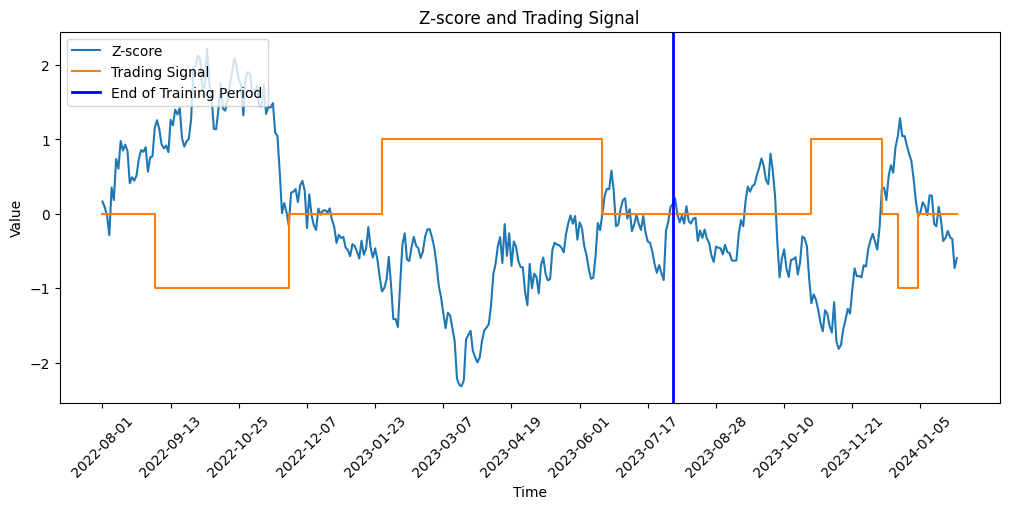

In [2]:
import quant.arbitrage
mu_ls = quant.arbitrage.estimate_mu_gamma_LS(filtered_data["CMS"],filtered_data["DTE"], 1)['mu']
gamma_ls = quant.arbitrage.estimate_mu_gamma_LS(filtered_data["CMS"],filtered_data["DTE"], 1)['gamma']
weight_ls, spread_ls = quant.arbitrage.compute_spread(filtered_data["CMS"],filtered_data["DTE"], gamma_ls, mu_ls)
z_score_ls, signal_ls = quant.arbitrage.generate_signal(spread_ls, -1, 1, pct_training = 2/3)

### 2.3.2 Rolling Least Squares Method

In a practical trading environment, when we account for the possibility that the parameters $\mu$and 
$\gamma$ may change over time, we need to adapt our strategy to use a rolling window for estimation. This approach updates the estimates of those continuously as new data comes in, allowing the model to adapt to changes in the underlying economic relationship between the two assets.

In a dynamic market where  $\mu$and $\gamma$ vary over time, we can define the spread as:

$$
z_t = y_{1t} - \gamma_t y_{2t} = \mu_t + \epsilon_t
$$

Here, $\mu_t$ represents the time-varying equilibrium value and $\gamma_t$ is the time-varying cointegration factor. To estimate these variables, we use a rolling window approach with a lookback period of $T_{\text{lookback}}$. The rolling least squares problem is formulated as:

$$
minimize_{\mu_{t_0}, \gamma_{t_0}} \sum_{l=t_0-T_{\text{lookback}}+1}^{t_0} (y_{1l} - (\mu + \gamma y_{2l}))^2
$$

where $t_0$ is the current time index, and the window spans from $t_0-T_{\text{lookback}}+1$ to $t_0 $.

For practical trading signals, we normalize the spread to a Z-score:

$$
Z_{\text{score}_t} = \frac{z_t - \mathbb{E}[z]t}{\text{Std}[z]t}
$$

where $\mathbb{E}[z]t$ is the varying mean and ${Std}[z]t$ is the varying standard deviation of $z_t$. 

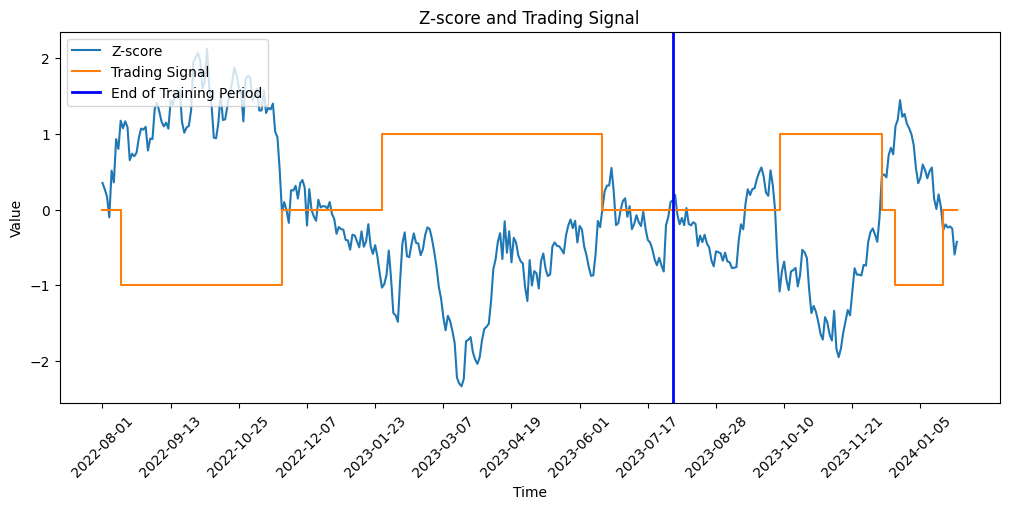

In [5]:
mu_rolling_ls = quant.arbitrage.estimate_mu_gamma_rolling_LS(filtered_data["CMS"],filtered_data["DTE"], 300, 14, 1)['mu']
gamma_rolling_ls = quant.arbitrage.estimate_mu_gamma_rolling_LS(filtered_data["CMS"],filtered_data["DTE"], 300, 14, 1)['gamma']
weight_rolling_ls, spread_rolling_ls = quant.arbitrage.compute_spread(filtered_data["CMS"],filtered_data["DTE"], gamma_rolling_ls, mu_rolling_ls)
z_score_rolling_ls, signal_rolling_ls = quant.arbitrage.generate_signal(spread_rolling_ls, -1, 1, pct_training = 2/3)

### 2.3.3 Kalman Filter

The Kalman filter provides a method for inferring the hidden state in a dynamic system, where the state evolves over time with some uncertainty (state transition noise) and the observations are noisy reflections of the underlying state. The Kalman filter equations represent a linear Gaussian state-space model.

The state-space representation of the time-varying fit using the Kalman filter is specified by the state transition equation and the observation equation:

- State transition equation:
$$
\alpha_{t+1} = T_t \alpha_t + R_t \eta_t
$$
- Observation equation:
$$
y_{1t} = Z_t \alpha_t + \epsilon_t
$$

where:
- $\alpha_t \equiv \begin{bmatrix} \mu_t \\ \gamma_t \end{bmatrix}$ is the hidden state vector at time $t$.
- $T_t \equiv \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$ is the state transition matrix, which indicates that the states $\mu_t$ and $\gamma_t$ are assumed to follow a random walk without drift.
- $R_t \equiv \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$ is the matrix that applies to the state transition noise $\eta_t$.
- $\eta_t \sim \mathcal{N}(0, Q_t)$ is the state transition noise with covariance matrix $Q_t = \begin{bmatrix} \sigma_{\mu}^2 & 0 \\ 0 & \sigma_{\gamma}^2 \end{bmatrix}$.
- $Z_t \equiv \begin{bmatrix} 1 & y_{2t} \end{bmatrix}$ is the observation coefficient matrix, relating the hidden state to the observation.
- $\epsilon_t \sim \mathcal{N}(0, h_t)$ is the i.i.d. observation noise with variance $h_t = h$.

The initial state $\alpha_1$ is assumed to follow a normal distribution with mean $a_1$ and covariance $P_1$.

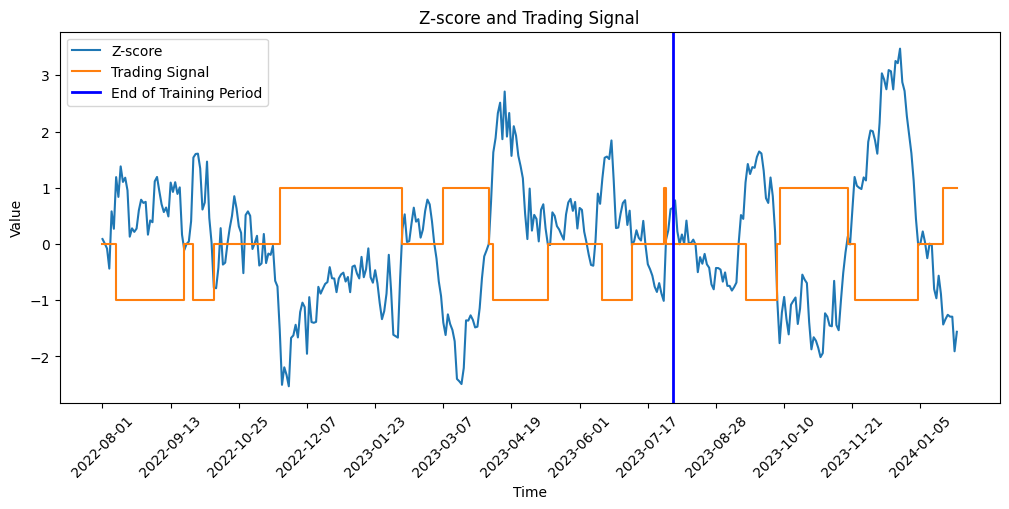

In [3]:
mu_KF = quant.arbitrage.estimate_mu_gamma_kalman_filter(filtered_data["CMS"],filtered_data["DTE"], 1)['mu']
gamma_KF = quant.arbitrage.estimate_mu_gamma_kalman_filter(filtered_data["CMS"],filtered_data["DTE"], 1)['gamma']
weight_KF, spread_KF = quant.arbitrage.compute_spread(filtered_data["CMS"],filtered_data["DTE"], gamma_KF, mu_KF)
z_score_KF, signal_KF = quant.arbitrage.generate_signal(spread_KF, -1, 1, pct_training = 2/3)

### 3. Empirical Results

We calibrated the parameters for the proposed trading strategies using historical data spanning one year (August 2022 to July 2023). Subsequently, we conducted a six-month backtesting exercise from August 2023 to January 2024 to evaluate the strategies' performance. Each transaction within the backtesting framework incurred a cost of 0.01%, mirroring realistic trading conditions; however, the costs associated with short selling financing were not considered in this analysis. The strategies employed the closing prices of each pair for the execution of trades.

### 3.1 Strategy profits and Risk metrics

Table 1 presents a summary of the returns generated by three distinct strategies: least squares (LS), rolling least squares (RLS), and Kalman filter (KF). In constructing the portfolios, we selected the top five pairs, assigning equal weights to each. The within-pair weights were based on the gamma value derived from each respective strategy. Over the trading period, all three strategies yielded returns that surpassed the benchmark. Notably, the LS strategy, being the most constrained, delivered the smallest excess return relative to the benchmark. Contrastingly, strategies incorporating time-varying parameters—RLS and KF—achieved significantly higher returns than the LS approach. Of these, the RLS methodology exhibited the most substantial returns, underscoring the benefits of adapting to time-varying market dynamics.

An analysis of risk metrics reveals that the strategies with time-varying parameters not only improved returns but also reduced volatility and exhibited smaller maximum drawdowns (MDD) when compared to the performance of individual pairs. This reduction in risk can be attributed to the diversification effect achieved by combining different pairs within the portfolios. These findings are consistent with existing literature [1], which suggests that as the number of pairs in a portfolio increases, the overall standard deviation of the portfolio decreases. Furthermore, diversification appears to positively influence the range of realized returns, raising the minimum realized return while maintaining a relatively stable maximum realized excess return.

In [12]:
pd.read_excel('dataframe_result.xlsx')

,Category,LS Strategy,Rolling LS Strategy,KF Strategy,Benchmark
0,Annual return,0.042054,0.046080,0.036702,0.151804
1,Cumulative returns,0.020810,0.022781,0.018186,0.073221
2,Annual volatility,0.028519,0.029816,0.024574,0.117536
3,Sharpe ratio,1.458651,1.525845,1.479067,1.261072
4,Calmar ratio,2.358478,3.737354,2.751569,1.477181
5,Stability,0.634913,0.831705,0.702658,0.436442
6,Max drawdown,-0.017831,-0.012330,-0.013339,-0.102766
7,Omega ratio,1.305833,1.343162,1.306706,1.227261
8,Sortino ratio,2.632611,2.652674,2.471873,1.873965
9,Skew,1.200482,1.074485,0.771192,-0.079010


To analyze mean-reverting behavior, we would typically look at the spread between two stocks or the residuals from a regression if you're looking for cointegration. In the context of a linear regression, one common approach is to regress the normalized prices of one stock against another to determine if there is a long-run equilibrium relationship between them. If such a relationship exists, the residuals from this regression would be expected to be mean-reverting. For instance, for rolling_ls method on DTE and CMS equity, one can observe the relationship as follows.

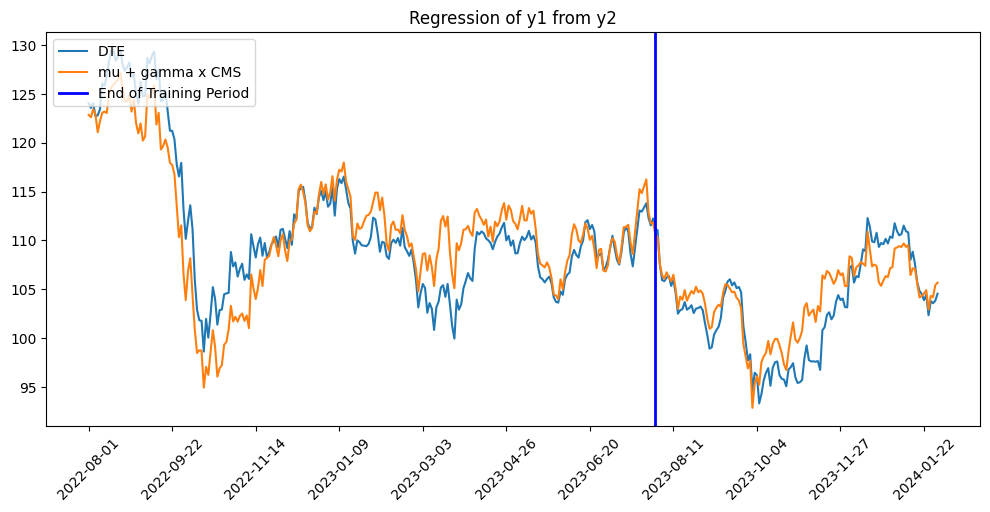

In [8]:
quant.helpers.plot_regression_lines(mu_rolling_ls, gamma_rolling_ls, filtered_data["DTE"], filtered_data["CMS"], 2/3)

### 3.2 Implications

The implications of these results are twofold. First, they validate the hypothesis that dynamic modeling of pairs trading strategies can capture and exploit evolving market inefficiencies more effectively than static models. Second, they confirm the risk-reducing benefits of diversification within a pairs trading portfolio context. The consistent performance of the RLS and KF strategies over the LS approach suggests that incorporating adaptive mechanisms is beneficial for pairs trading strategies, aligning with the broader trend towards more sophisticated quantitative trading models.

### 4. Conclusion

This study has investigated an equity trading strategy predicated on the concept of co-integrated stock prices within the bounds of a reasonably efficient market, commonly referred to as pairs trading on Wall Street. Pairs were constituted from stocks identified as close substitutes through a minimum-distance criterion, utilizing a specified metric within the price space. Our empirical results substantiate that trading on these carefully selected pairs of stocks can yield profitable outcomes, even when accounting for conservative estimates of transaction costs.

The promising evidence provided by our study on pairs trading strategy, grounded in the principle of co-integrated stock prices, sets the stage for a series of intriguing questions that merit further investigation. While our research affirms that such a strategy can be profitable in a semi-efficient market, even after factoring in transaction costs, the scope of our analysis was inherently limited by the number of pairs and the duration of the study.

A critical extension of this work would involve expanding the portfolio construction process. By systematically increasing the number of pairs within a portfolio, future research could evaluate the impact of diversification on the risk-return profile of the trading strategy. This line of inquiry would not only illuminate the potential for scaling up the pairs trading approach but also help in understanding the diminishing marginal returns, if any, associated with portfolio expansion.

Another essential avenue for exploration is the temporal robustness of the strategy. Our study's observation window of one and a half years offers a snapshot of the strategy's performance; however, a longitudinal analysis covering a broader range of market conditions could provide a more definitive assessment of its enduring efficacy. This would be particularly insightful in discerning how the pairs trading strategy weathers various market cycles, including bull and bear phases, and whether profitability sustains in the long run.

Delving into sector-specific performance also presents a fertile ground for research. A detailed examination of pairs within individual industry sectors could shed light on the differential behavior of co-integrated pairs across distinct market segments. Such sectorial analysis could reveal unique characteristics that could be exploited for improved trading strategies or identify sectors where the strategy underperforms due to inherent industry volatility or regulatory changes.

Additionally, the interaction between market conditions and the pairs trading strategy's performance is a subject worthy of a deeper dive. Investigating how the strategy holds up during periods of high volatility or market drawdowns could significantly enhance our understanding of its resilience and adaptability.

Lastly, a more nuanced approach to transaction costs and market impact would refine the understanding of the strategy's net profitability. Future studies could incorporate a broader range of transaction costs, including taxes, slippage, and the potential market impact of large trades, which could better reflect the real-world constraints faced by traders.

In conclusion, while our research provides a solid foundation for pairs trading as a viable strategy, the full spectrum of its application and potential remains to be thoroughly explored. The avenues outlined above not only pave the way for a comprehensive understanding of the strategy's strengths and limitations but also offer a blueprint for advancing the field of quantitative finance.



[1] Gatev, E., Goetzmann, W. N., & Rouwenhorst, K. G. (2006). Pairs trading: Performance of a relative-value arbitrage rule. The Review of Financial Studies, 19(3), 797-827. 
[2] Vidyamurthy, G. (2004). Pairs Trading: quantitative methods and analysis (Vol. 217). John Wiley & Sons.


### Appendix. Historical Position of LS Rolling Strategy

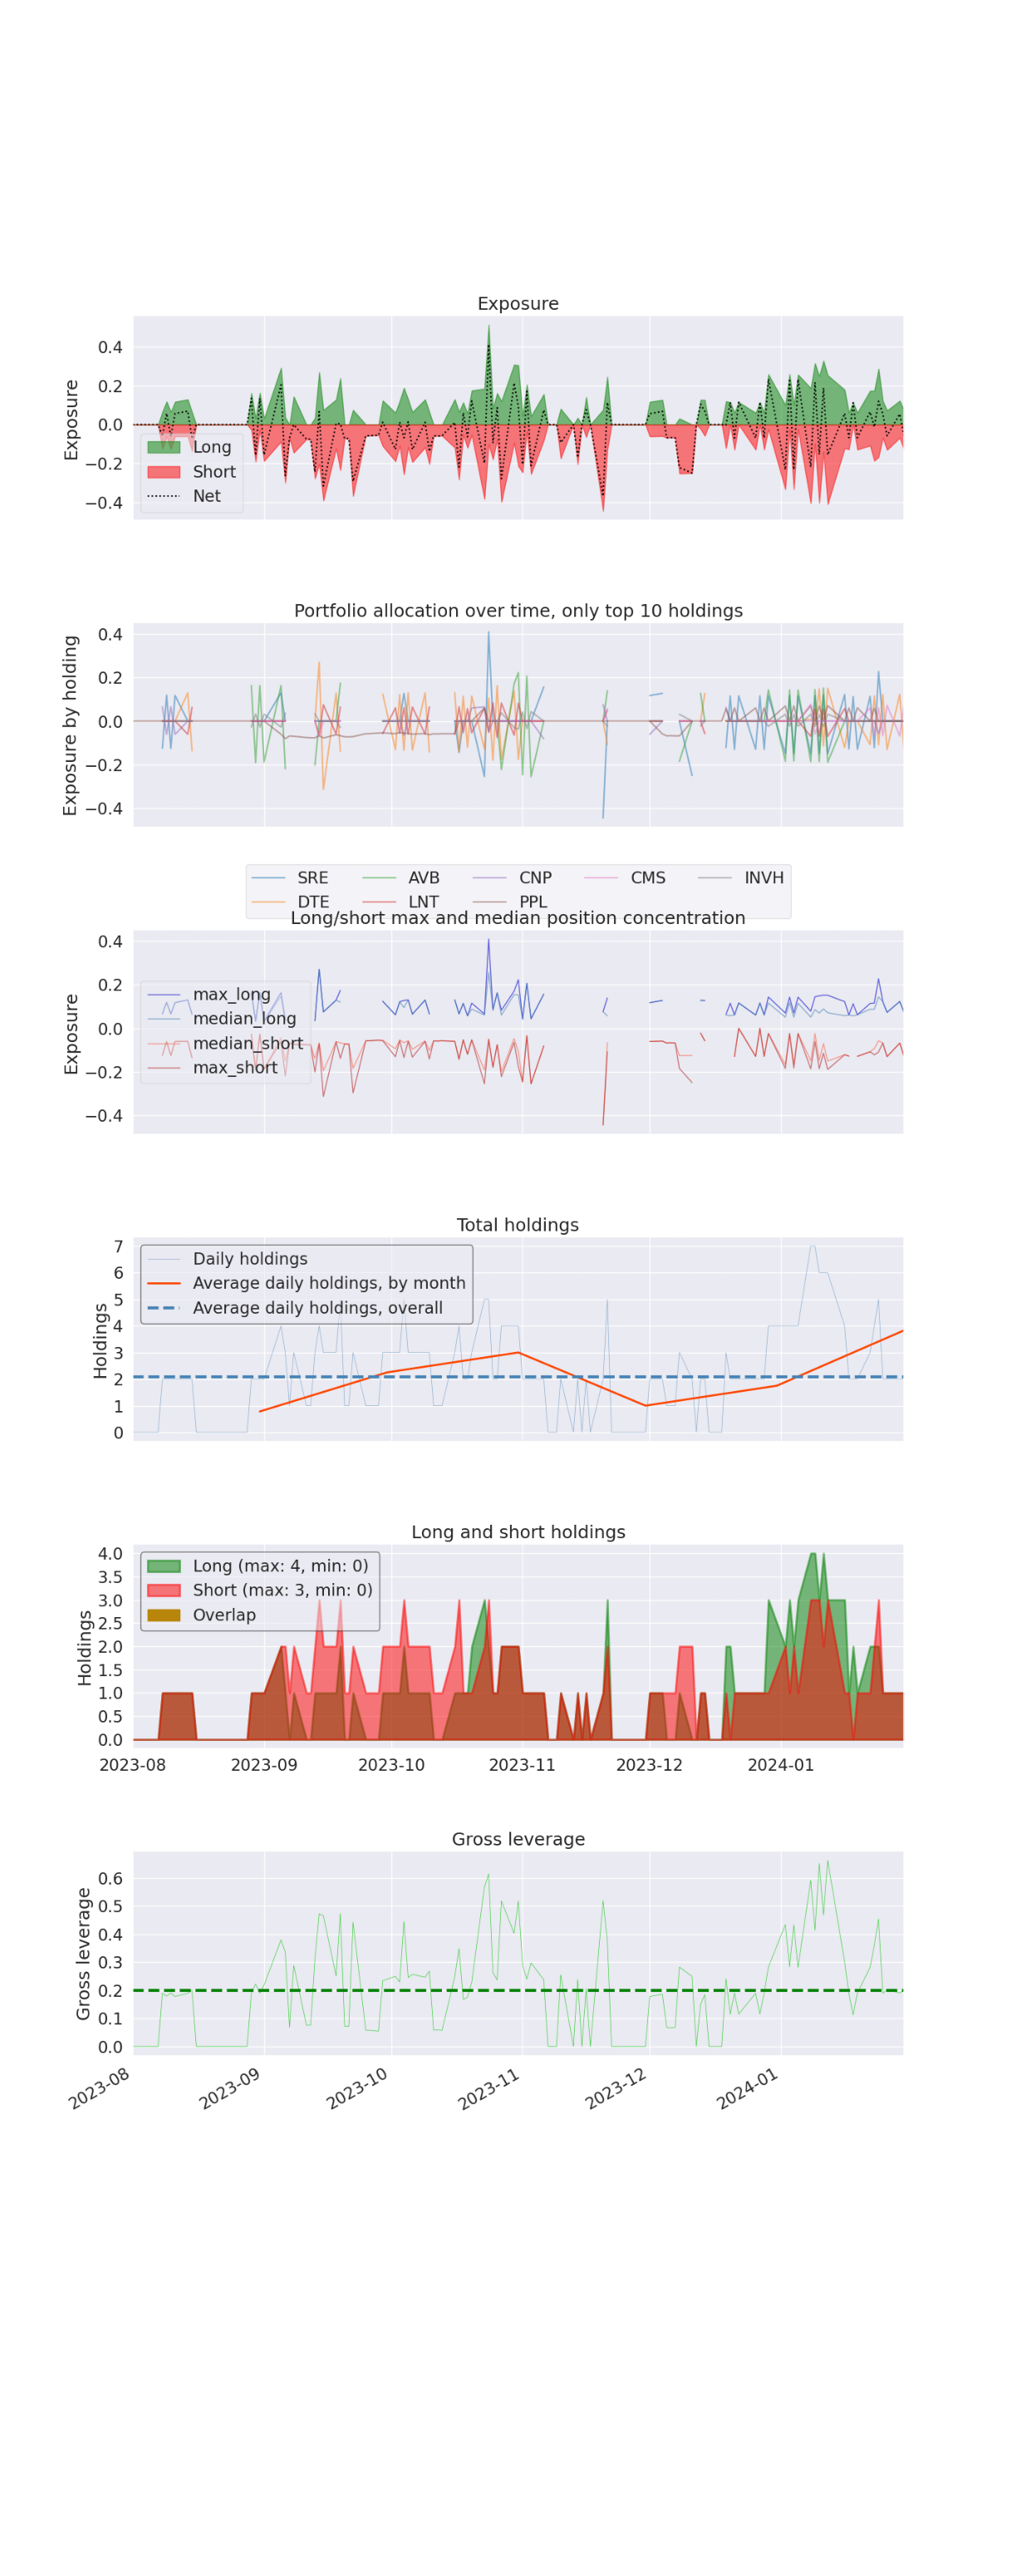

In [23]:
# from IPython.display import Image, display
# display(Image(filename='./pyfolio_positions_tear_sheet.png'))
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the image
img = mpimg.imread('./pyfolio_positions_tear_sheet.png')

# Create a figure with a specific size
plt.figure(figsize=(50, 40))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()